# Minimization with zfit

zfit is a project that aims to establish a fitting framework in Python capabale enough to perform High Energy Physics analysis. The project focuses on two aspects:
 - fast and scalable fits
 - well defined workflow

The first aspect is achieved by using a backend such as TensorFlow (or JAX in the future). There are dedicated tutorials available on this aspect but it is, for the beginning, not our first priority.

The second aspect concerns the workflow, which is depicted below.

![zfit workflow](images/zfit_workflow.png)

After this, other libraries such as hepstats will pick up the elements created with zfit and do further statistical inference.

For a user, the features of zfit and hepstats broadly include:
 - build complicated models in multiple dimensions allowing for composite models
 - strong support for custom created models in pure Python
 - (likelihood) minimization for unbinned (extended) fits including arbitrary constraints
 - sPlot and sWeights
 - Confidence Intervalls and significance calculation

For a developer of a fitting (related) library, zfit aims to establish an ecosystem with a stable API and to provide base classes that allow to build on top; the focus is on a stable core, not on a lot of content in zfit.

## What is zfit and hepstats?

To get an impression of what zfit and hepstats can do, we'll use a simple example to determine the upper limit of a signal.

In [1]:
import zfit
import hepstats
import numpy as np
import mplhep

/home/jonas/anaconda3/envs/pyhep2021/lib/python3.9/site-packages/zfit/__init__.py:37: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn("TensorFlow warnings are by default suppressed by zfit."


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f28c863df40>, errorbar=None, legend_artist=None)]

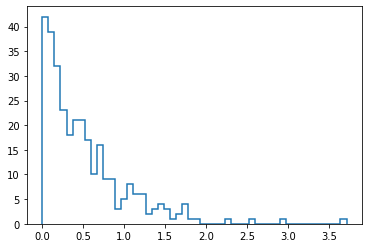

In [2]:
# create some data
bounds = (0.1, 3.0)
bkg = np.random.exponential(0.5, 300)
peak = np.random.normal(1.2, 0.1, 10)
data = np.concatenate((bkg, peak))
data_np = data[(data > bounds[0]) & (data < bounds[1])]
N = data.size

mplhep.histplot(np.histogramdd(data, bins=50))

## building the likelihood: model and data

In [3]:
obs = zfit.Space('x', limits=bounds)
data = zfit.Data.from_numpy(obs=obs, array=data_np)

# create the parameters
lambda_ = zfit.Parameter("lambda", -2.0, -4.0, -1.0)
Nsig = zfit.Parameter("Nsig", 1., -20., N)
Nbkg = zfit.Parameter("Nbkg", N, 0., N*1.1)

# create the total model as a sum of two extended pdfs
signal = zfit.pdf.Gauss(obs=obs, mu=1.2, sigma=0.1).create_extended(Nsig)
background = zfit.pdf.Exponential(obs=obs, lambda_=lambda_).create_extended(Nbkg)
model = zfit.pdf.SumPDF([signal, background])

# loss function from model and data
loss = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)

# minimization (not required, just for demonstration)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(loss)
result.hesse()
print(result)

2021-07-06 23:57:16.416630: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-06 23:57:16.450338: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-06 23:57:16.450723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro P1000 computeCapability: 6.1
coreClock: 1.5185GHz coreCount: 4 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 89.53GiB/s
2021-07-06 23:57:16.450822: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-06 23:57:16.450899: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcubla

FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_3, Composed_autoparam_4]] data=[<zfit.core.data.Data object at 0x7f28d53a9b50>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 1.8e-06 │ 1002        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    minuit_hesse    at limit
------  -------  --------------  ----------
Nsig        5.3     +/-     5.5       False
Nbkg      246.7     +/-      16       False
lambda   -1.988     +/-    0.14       False


## Inference: setting an upper limit

In [5]:
from hepstats.hypotests.calculators import AsymptoticCalculator
from hepstats.hypotests import UpperLimit
from hepstats.hypotests.parameters import POI, POIarray

# Use the loss and minimizer from zfit
calculator = AsymptoticCalculator(loss, minimizer, asimov_bins=100)

# define null and alternative hypothesis
poinull = POIarray(Nsig, np.linspace(0.0, 50, 40))
poialt = POI(Nsig, 0)
ul = UpperLimit(calculator, poinull, poialt)
ul.upperlimit(alpha=0.05, CLs=True)

Get fit best values!

Get fitted values of the nuisance parameters for the alternative hypothesis!
FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_3, Composed_autoparam_4]] data=[<zfit.core.data.Data object at 0x7f28d53a9b50>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 9.9e-05 │ 1002        │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
Nbkg      251.8       False
lambda   -1.933       False

Observed upper limit: Nsig = 15.951080987478734
Expected upper limit: Nsig = 11.270136679238199
Expected upper limit +1 sigma: Nsig = 16.459745229897027
Expected upper limit -1 sigma: Nsig =

{'observed': 15.951080987478734,
 'expected': 11.270136679238199,
 'expected_p1': 16.459745229897027,
 'expected_m1': 7.8372845095715755,
 'expected_p2': 23.357891175251147,
 'expected_m2': 5.701090917576093}

Pretty simpel. But before we will have a deeper look into the components and better understand the libraries, we will focus on recent news in zfit: minimizers.

## Minimization: API and workflow

The workflow of zfit is designed that each stage is maximally decoupled and can be used as standalone as possible.

**You don't need to use zfit to use zfit.** But you can use the pieces that you want to.

*(this has it's limits: if we don't use zfit models in the loss, most hepstat functionality won't work: the one that relies on knowing the API of the model. But it's easy to implement your function in a zfit model.)*



In [ ]:
# set everything to numpy mode (if anything else than zfit.z is used)
zfit.run.set_autograd_mode(False)
zfit.run.set_graph_mode(False)

In [7]:
# create a problem
def func(x):
    x = np.array(x)  # make sure it's an array
    return np.sum((x - 0.1) ** 2 + x[1] ** 4)

# we need to set the errordef
func.errordef = 0.5

# initial parameters
params = [1, -3, 2, 1.4, 11]

# create our favorite minimizer
minimizer = zfit.minimize.Minuit()

# minimize
result = minimizer.minimize(func, params)

# estimate errors
result.hesse()
result.errors(method='minuit_minos')
print(result)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 0.00015 │ 0.0005689   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name            value    minuit_hesse         minuit_minos    at limit
------------  -------  --------------  -------------------  ----------
autoparam_10  0.09903     +/-    0.71  -   0.71   +   0.71       False
autoparam_11   0.0916     +/-    0.63  -   0.54   +   0.42       False
autoparam_12  0.09794     +/-    0.71  -   0.71   +   0.71       False
autoparam_13  0.09859     +/-    0.71  -   0.71   +   0.71       False
autoparam_14   0.0882     +/-    0.71  -    0.7   +   0.72       False


### Why do we need more minimizers?

There are many good minimizers (iminuit, SciPy, ...) out there. So why even consider to implement something new?

zfit merely wraps existing minimizers with the goal of a clean interface and behavior.
There are essentially two parts of a minimizer:
 - Configuration of the algorithm: this depends a lot on the chosen algorithm (trust radius, hessian approximation, ...)
 - minimization: independent of the algorithm. Needs a function, initial parameters (and more information on the function)

This led to two design choices:
 - every minimizer is a class and the initializer takes the configuration and has its own documentation *but knows nothing about the minimization function*
 - one method `minimize` which takes the function *but no configuration of the algorithm*

Therefore, the minimizers in zfit are naturally stateless and can be interchanged *without changing the rest of the script*. They are a "configuration holding class".

**Not obvious (and not the only possible) choices.**

**iminuit** is stateful: more massaging around with the function minimization and more (efficient) functionality that can use the full state information *(->custom minimizer in zfit)*
**SciPy** mixes both into one function: design choice that leads to cluttered interface as everything is mixed together ([here](https://github.com/scipy/scipy/issues/13524) or [here](https://github.com/scipy/scipy/issues/13754))

Most minimizers do not offer the combination of
 - gradients
 - arbitrary constraints
 - unified and solid termination criteria
 - (uncertainty estimation)

**This is the role that zfit minimizers fulfill**

## zfit minimizer creation

Every minimizer [can take arbitrary arguments](https://zfit.readthedocs.io/en/latest/user_api/minimize/minimizers.html#minimizers), but there are many shared ones, such as:
 - tol: tolerance for which to terminate the minimization
 - verbosity (from 0 to 10): the verbosity of the minimizer
 - gradient (if available): `False` or `'zfit'` uses internal gradients (numerically if needed), `True` or other allowed values use the minimizers own gradient function
 - criterion: convergence criterion (default EDM)
 - maxiter: approximate number of function evaluations
 - strategy: zfit strategy to deal with NaNs

We can now create a minimizer of our choice

In [10]:
# create our favorite minimizer
# minimizer = zfit.minimize.IpyoptV1()
# minimizer = zfit.minimize.Minuit()
minimizer = zfit.minimize.ScipyTrustConstrV1()
# minimizer = zfit.minimize.NLoptLBFGSV1()

Done. Now we can see how to minimize the function. Therefore we need a loss.

## zfit "loss"

Minimizers accept anything that:
 - takes one positional argument, the array of values to evaluate the loss function at and returns the function value
 - has an attribute `errordef`

A zfit loss already fulfils this criteria.

### intermezzo: iminuit

iminuit accepts the same functions! So anything that you want to minimize with zfit also works with iminuit out-of-the-box.

A zfit loss can be called with an array of elements, where the order corresponds to the return value of `get_params()`. Let's re-use the loss we built above and try it out

In [26]:
loss.get_params()

OrderedSet([<zfit.Parameter 'Nsig' floating=True value=5.372>, <zfit.Parameter 'Nbkg' floating=True value=234>, <zfit.Parameter 'lambda' floating=True value=-2.135>])

In [28]:
from iminuit import Minuit

minuit = Minuit(loss, [10, 250, -2.5])
minuit.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 1002                       │              Nfcn = 55               │
│ EDM = 3.83e-05 (Goal: 0.0001)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0   │     5     │     6     │            │            │         │         │       │
│ 1 │ x1   │    247    │    17     │            │            │         │         │       │
│ 2 │ x2   │   -1.99   │   0.14    │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬──────────────────────┐
│    │     x0     x1     x2 │
├────┼──────────────────────┤
│ x0 │   30.4  -24.9 -0.266 │
│ x1 │  -24.9    271  0.265 │
│ x2 │ -0.266  0.265 0.0207 │
└────┴──────────────────────┘

### the minimize method

Minimize takes exactly three arguments:
 - loss: the function to minimize
 - params: information about the parameters such as starting point
 - init (optional): a `FitResult` from a previous minimization that contains additional infromation

In [31]:
# for a more fine-grained control
params = {
    'value': [1, -3, 2],  # mandatory
    'lower': [-2, -5, -5],  # lower bound, optional
    'upper': [2, 4, 5],  # upper bound, optional
    'step_size': [0.1] * 3,  # initial step size, optional
    'name': ['a', 'b', 'c']  # names, optional
}

# minimize
result = minimizer.minimize(func, params)
print(result)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<ScipyTrustConstrV1 SciPy trust-constr V1 tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.6e-05 │ 0.0002956   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
a       0.09516       False
b       0.09583       False
c       0.09866       False


### Comparable criterion

As we've seen, we can fully mix or swap minimizers in zfit and use the same code for the minimization.

The result shows also an "edm", the Estimated Distance to Minimum, which is also the criterion used by iminuit. zfit minimizers use by default the same, which makes results comparable.

However, this criterion needs the (approximate) inverse Hessian matrix and therefore can be quite slow to compute in general, especially if the minimizer does not provide an approximation (if they do, this is used). More criteria are welcome to be added to zfit!

## FitResult

The return value is a FitResult. While there are already a few standards, such as Scipys OptimizeResult, zfits FitResult is more powerful: it also contains uncertainty calculations, both a hessian approximation as well as a profiling method ("minos").

But first, lets look at a few useful flags.

In [46]:
result.valid  # tells if the fit is valid: converged, not at limits etc

True

In [48]:
result.fmin  # minimum value

0.00029560056005886753

In [53]:
result.params  # the parameters in a dict-like form (use print for a nice view)

{<zfit.Parameter 'a' floating=True value=0.09516>: {'value': 0.0951616473148872, 'minuit_hesse': {'error': 0.7070661439265744, 'cl': 0.68268949}, 'hesse_np': {'error': 0.7071067780639626, 'cl': 0.68268949}, 'hesse_90cl': {'error': 1.1630871536766714, 'cl': 0.9}, 'zfit_error': {'lower': -0.7022870697263754, 'upper': 0.7119636327155465, 'cl': 0.68268949}, 'minuit_minos': {'lower': -0.7022874781379412, 'upper': 0.7119617569082848, 'is_valid': True, 'upper_valid': True, 'lower_valid': True, 'at_lower_limit': False, 'at_upper_limit': False, 'nfcn': 66, 'original': <MError number=0 name='a' lower=-0.7022874781379412 upper=0.7119617569082848 is_valid=True lower_valid=True upper_valid=True at_lower_limit=False at_upper_limit=False at_lower_max_fcn=False at_upper_max_fcn=False lower_new_min=False upper_new_min=False nfcn=66 min=0.09516164731488708>, 'cl': 0.68268949}}, <zfit.Parameter 'b' floating=True value=0.09583>: {'value': 0.09582640373782722, 'minuit_hesse': {'error': 0.6550499294695796, 

In [55]:
result.info  # contains (non everything is guaranteed) additional infromation including the "original" result

{'n_eval': 19,
 'n_iter': 19,
 'niter': 19,
 'grad': array([-0.00967671,  0.00221215, -0.00268781]),
 'inv_hesse': None,
 'hesse': None,
 'message': None,
 'evaluator': <zfit.minimizers.evaluation.LossEval at 0x7f28845cd130>,
 'original':  barrier_parameter: 0.020000000000000004
  barrier_tolerance: 0.020000000000000004
           cg_niter: 49
       cg_stop_cond: 4
             constr: [array([0.09516165, 0.0958264 , 0.0986561 ])]
        constr_nfev: [0]
        constr_nhev: [0]
        constr_njev: [0]
     constr_penalty: 1.0
   constr_violation: 0.0
     execution_time: 2.1780712604522705
                fun: 0.00029560056005886753
               grad: array([-0.00967671,  0.00221215, -0.00268781])
                jac: [<3x3 sparse matrix of type '<class 'numpy.float64'>'
 	with 3 stored elements in Compressed Sparse Row format>]
    lagrangian_grad: array([-0.0058021 ,  0.00308853, -0.00234229])
            message: '`gtol` termination condition is satisfied.'
             method

### Uncertainty estimation

The `FitResult` implements, for both the hessian and profiling, the exposed iminuit error methods as well as pure Python implementations (standalone, independent of iminuit).

In [33]:
result.hesse(method='minuit_hesse')

{<zfit.Parameter 'a' floating=True value=0.09516>: {'error': 0.7071067780639626,
  'cl': 0.68268949},
 <zfit.Parameter 'b' floating=True value=0.09583>: {'error': 0.6550406508956643,
  'cl': 0.68268949},
 <zfit.Parameter 'c' floating=True value=0.09866>: {'error': 0.7071067780639626,
  'cl': 0.68268949}}

In [34]:
result.hesse(method='hesse_np')

{<zfit.Parameter 'a' floating=True value=0.09516>: {'error': 0.7071067780639626,
  'cl': 0.68268949},
 <zfit.Parameter 'b' floating=True value=0.09583>: {'error': 0.6550406508956643,
  'cl': 0.68268949},
 <zfit.Parameter 'c' floating=True value=0.09866>: {'error': 0.7071067780639626,
  'cl': 0.68268949}}

In [35]:
print(result)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<ScipyTrustConstrV1 SciPy trust-constr V1 tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.6e-05 │ 0.0002956   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    minuit_hesse     hesse_np    at limit
------  -------  --------------  -----------  ----------
a       0.09516     +/-    0.71  +/-    0.71       False
b       0.09583     +/-    0.66  +/-    0.66       False
c       0.09866     +/-    0.71  +/-    0.71       False


Both uncertainties have been added to the result.

We can also choose a different name and a differenc cl!

In [37]:
result.hesse(method='hesse_np', name='hesse_90cl', cl=0.9)
print(result)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<ScipyTrustConstrV1 SciPy trust-constr V1 tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.6e-05 │ 0.0002956   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    minuit_hesse     hesse_np    hesse_90cl    at limit
------  -------  --------------  -----------  ------------  ----------
a       0.09516     +/-    0.71  +/-    0.71   +/-     1.2       False
b       0.09583     +/-    0.66  +/-    0.66   +/-     1.1       False
c       0.09866     +/-    0.71  +/-    0.71   +/-     1.2       False


We can also use the profiling methods in the same manner. Note that this returns two values: the errors in a dict as well as a new `FitResult` (in case a new minimum was found, otherwise `None`).

`errors` takes also a name and a cl argument.

In [41]:
result.errors(method='zfit_error')
result.errors(method='minuit_minos')
print(result)

/home/jonas/anaconda3/envs/pyhep2021/lib/python3.9/site-packages/tensorflow/python/util/deprecation.py:535: ExperimentalFeatureWarning: 'zfit_error' is still rather new. If it fails, please report it here: https://github.com/zfit/zfit/issues/new?assignees=&labels=bug&template=bug_report.md&title=zfit%20error%20fails.
  return func(*args, **kwargs)


FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<ScipyTrustConstrV1 SciPy trust-constr V1 tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.6e-05 │ 0.0002956   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    minuit_hesse     hesse_np    hesse_90cl           zfit_error         minuit_minos    at limit
------  -------  --------------  -----------  ------------  -------------------  -------------------  ----------
a       0.09516     +/-    0.71  +/-    0.71   +/-     1.2  -    0.7   +   0.71  -    0.7   +   0.71       False
b       0.09583     +/-    0.66  +/-    0.66   +/-     1.1  -   0.58   +   0.46  -   0.58   +   0.46       False
c       0.09866     +/-    0.71  +/-    0.71   +/-     1.2  -   0.71   + 

We see that both methods agree with each other!

In [58]:
params

{'value': [1, -3, 2],
 'lower': [-2, -5, -5],
 'upper': [2, 4, 5],
 'step_size': [0.1, 0.1, 0.1],
 'name': ['a', 'b', 'c']}

### chaining minimizers with init

The third argument to `minimize` contains additional information, it has to be a `FitResult`. This encodes the state of the minimizers and allows to "chain" minimizers!

We can either give loss and params as well *or, if we want to continue the exact same minimization*, just the result. The loss and params will automatically be taken from it.

In [71]:
minimizer2 = zfit.minimize.Minuit(tol=1e-6)
minimizer2.minimize(result)

FitResult of
<SimpleLoss model=[] data=[] constraints=[]> 
with
<Minuit Minuit tol=1e-06>

╒═════════╤═════════════╤══════════════════╤═════════╤═════════════╕
│ valid   │ converged   │ param at limit   │ edm     │ min value   │
╞═════════╪═════════════╪══════════════════╪═════════╪═════════════╡
│ True    │ True        │ False            │ 2.5e-12 │ 0.0002693   │
╘═════════╧═════════════╧══════════════════╧═════════╧═════════════╛

Parameters
name      value    at limit
------  -------  ----------
a           0.1       False
b       0.09488       False
c           0.1       False

This allows to have first a more global minimizer and then a more local one.

## Creating a custom minimizer

It wouldn't be a zfit feature if there wasn't a straightforward way to build your own minimizer ;)